# CART

In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

import numpy as np
import pandas as pd

from preprocess import data

np.random.seed(0)


In [37]:
x_tl = data["x_timed_lagged"].reset_index(drop=True).shift(1)
x_germany = data["x_germany"].reset_index(drop=True)
x_austria = data["x_austria"].reset_index(drop=True)
y_germany = data["y_germany"].reset_index(drop=True)
y_austria = data["y_austria"].reset_index(drop=True)

In [38]:
X_ger = pd.concat([x_germany, x_tl], axis=1).dropna().drop(columns=["DATE_FROM"]).reset_index(drop=True) #drop the first row of the df due to .shift(1)
X_aust = pd.concat([x_austria, x_tl], axis=1).dropna().drop(columns=["DATE_FROM"]).reset_index(drop=True)

y_ger = y_germany.iloc[1:].reset_index(drop=True)
y_aus = y_austria.iloc[1:].reset_index(drop=True)

## Experiments

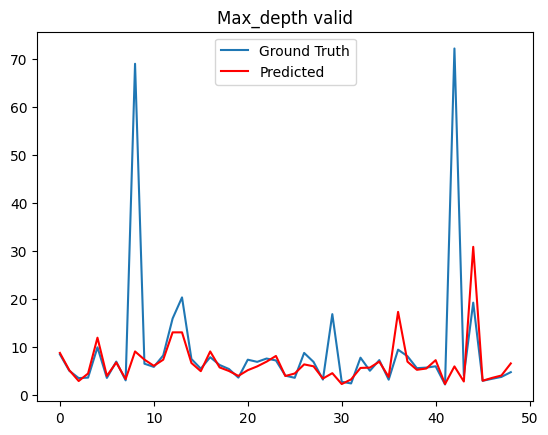

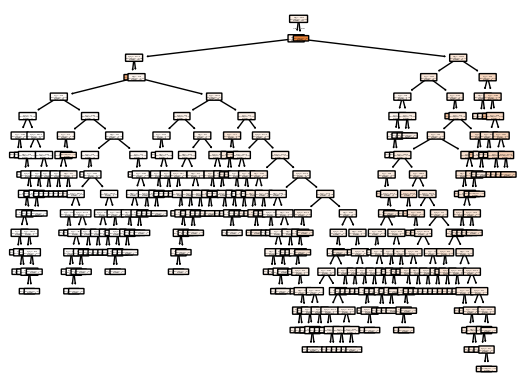

In [16]:
# Classical Train/Valid max depth

X_train, X_valid, y_train, y_valid = train_test_split(X_ger, y_ger, test_size=0.2, random_state=0)

max_depth = None  # Aucun maximum de profondeur pour un arbre maximal
regressor = DecisionTreeRegressor(max_depth=max_depth)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_valid)


plt.plot(y_valid.reset_index(drop=True), label='Ground Truth')
plt.plot(y_pred, color='red', label='Predicted')
plt.title('Max_depth valid')
plt.legend()
plt.show()

plot_tree(regressor, filled=True, rounded=True)
plt.show()

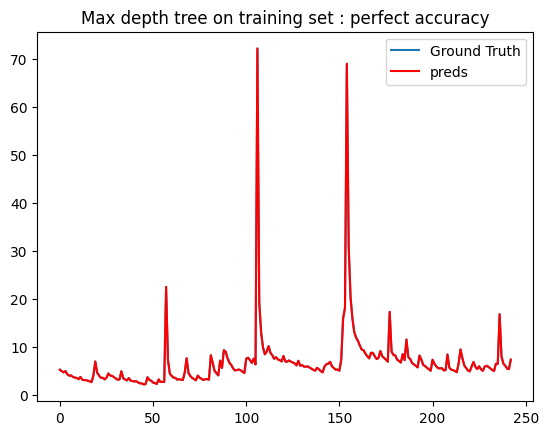

In [28]:
#Max Depth without train / valid split 

X_train = X_ger
y_train = y_ger

max_depth = None  
regressor = DecisionTreeRegressor(max_depth=max_depth)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_train)

plt.plot(y_train.reset_index(drop=True), label='Ground Truth')
plt.plot(y_pred, color='red', label='preds')
plt.title('Max depth tree on training set : perfect accuracy')
plt.legend()
plt.show()

## K-folds on max_depth (no pruning)

Profondeur optimale: 1


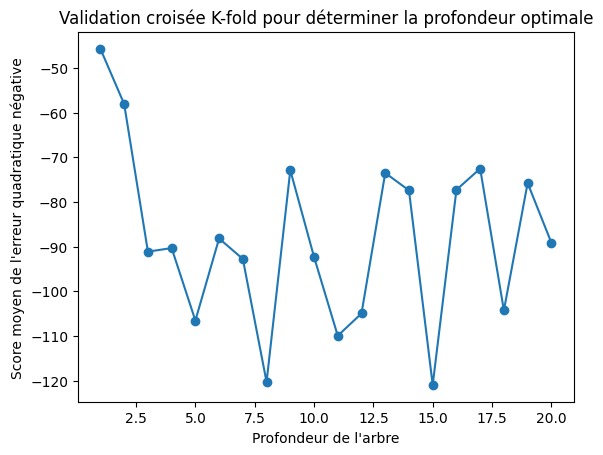

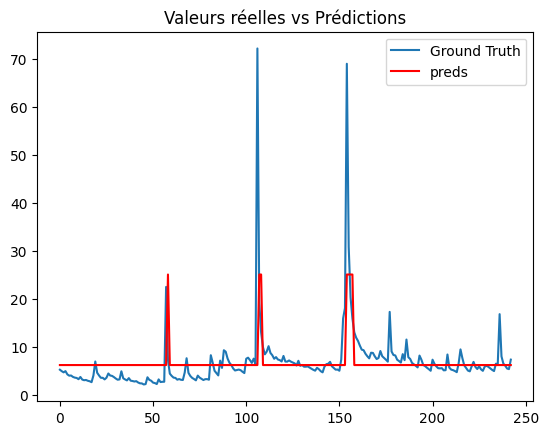

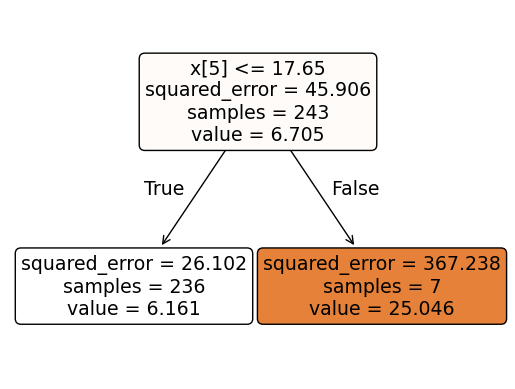

In [39]:
# Without train test split
X, y = X_ger, y_ger


kf = KFold(n_splits=5, shuffle=True, random_state=0)
depths = range(1, 21)
mean_scores = []

for depth in depths:
    regressor = DecisionTreeRegressor(max_depth=depth)
    scores = cross_val_score(regressor, X, y, cv=kf,  scoring='neg_mean_squared_error')
    mean_scores.append(np.mean(scores))

optimal_depth = depths[np.argmax(mean_scores)]
print(f'Profondeur optimale: {optimal_depth}')

plt.plot(depths, mean_scores, marker='o')
plt.xlabel('Profondeur de l\'arbre')
plt.ylabel('Score moyen de l\'erreur quadratique négative')
plt.title('Validation croisée K-fold pour déterminer la profondeur optimale')
plt.show()

regressor = DecisionTreeRegressor(max_depth=optimal_depth)
regressor.fit(X, y)
y_pred = regressor.predict(X)


plt.plot(y.reset_index(drop=True), label='Ground Truth')
plt.plot(y_pred, color='red', label='preds')
plt.title('Valeurs réelles vs Prédictions')
plt.legend()
plt.show()

plot_tree(regressor, filled=True, rounded=True)
plt.show()

## K-folds on max_depth with pruning 

Best ccp_alpha: 0.5398389533550945


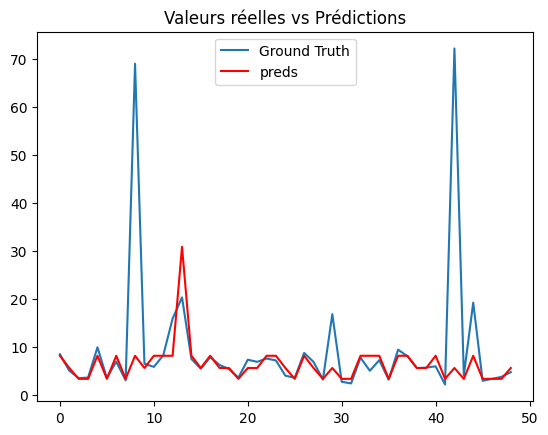

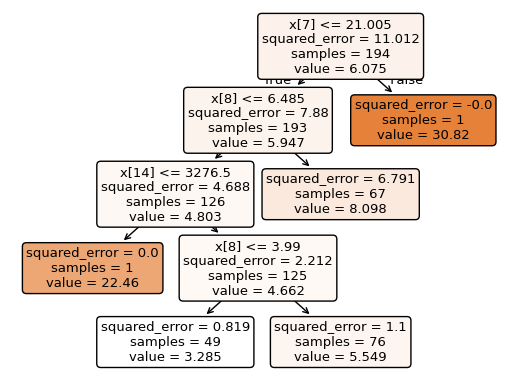

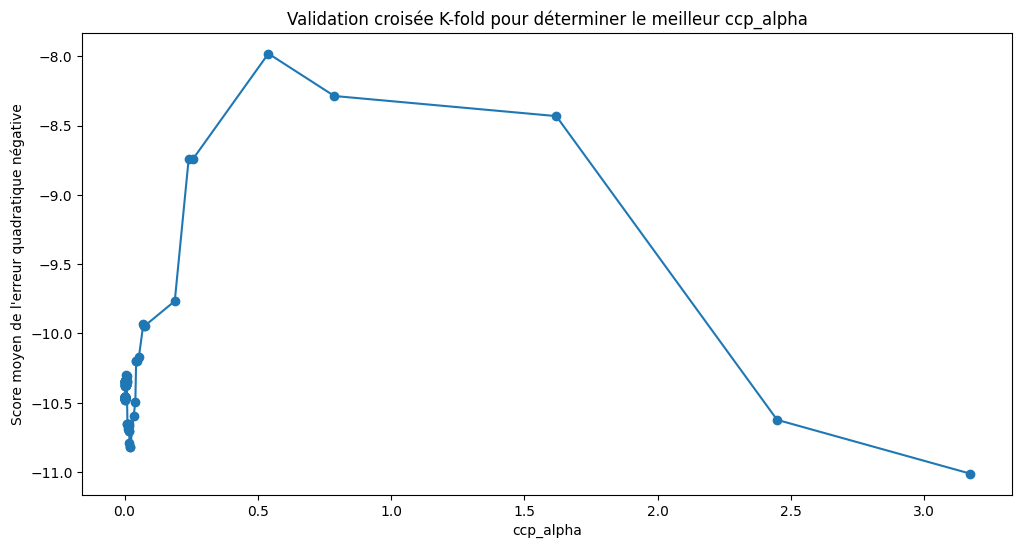

In [43]:

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)

path = regressor.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

kf = KFold(n_splits=5, shuffle=True, random_state=0)
mean_scores = []

for ccp_alpha in ccp_alphas:
    regressor = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(regressor, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    mean_scores.append(np.mean(scores))

best_ccp_alpha = ccp_alphas[np.argmax(mean_scores)]
print(f'Best ccp_alpha: {best_ccp_alpha}')

regressor = DecisionTreeRegressor(random_state=0, ccp_alpha=best_ccp_alpha)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_valid)


plt.plot(y_valid.reset_index(drop=True), label='Ground Truth')
plt.plot(y_pred, color='red', label='preds')
plt.title('Valeurs réelles vs Prédictions')
plt.legend()
plt.show()

plot_tree(regressor, filled=True, rounded=True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(ccp_alphas, mean_scores, marker='o')
plt.xlabel('ccp_alpha')
plt.ylabel('Score moyen de l\'erreur quadratique négative')
plt.title('Validation croisée K-fold pour déterminer le meilleur ccp_alpha')
plt.show()